In [1]:
import torch
import torch.nn as nn
import pandas as pd
from chessEngine import ChessEncoder, MLPEngine
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

# Preprocessing

In [2]:
df = pd.read_csv('fen_analysis.csv').sample(frac=1)[:30000] # This shuffles the rows
df

,fen_value,score
21024,rn1qkb1r/1bp2ppp/pp3n2/3p4/3P4/3BPN2/PP1N1PPP/...,8
219449,rnbqkbnr/pppppppp/8/8/8/1P6/P1PPPPPP/RNBQKBNR ...,26
157737,2r3k1/5pp1/7p/8/5PP1/2p4P/1r3RK1/8 b - - 2 53,667
23033,r1bqkb1r/pp1n1p1p/3p1np1/2pPpP2/4P3/2N5/PPP3PP...,113
124325,2kr1bnr/4pppp/pp4b1/3PNq2/5B2/2Q5/PPP2PPP/R4RK...,-828
...,...,...
42807,rnbqkbnr/ppp1pppp/3p4/8/3P4/8/PPP1PPPP/RNBQKBN...,46
293773,8/4pk2/4b1p1/6P1/1ppR1P2/8/1r5K/7N w - - 0 37,-553
181322,8/R4pp1/5bk1/7p/2r2P2/p7/P5KP/8 b - - 0 34,498
296689,5rk1/5ppp/pb2pn2/4N3/2R5/1P3N2/P4PPP/6K1 b - -...,-53


In [3]:
encoder_object = ChessEncoder()

In [4]:
fen_encodings = []
for fen_i in df['fen_value']:
    encoded_fen = encoder_object.encode_fen(fen_i)
    fen_encodings.append(encoded_fen)

In [5]:
X = torch.tensor(fen_encodings, dtype=torch.int32)

In [6]:
score_encodings = []
for y_i in df['score']:
    # print(y_i)
    encoded_score = encoder_object.encode_score(str(y_i))
    score_encodings.append(encoded_score)
y = torch.tensor(score_encodings, dtype=torch.float32)

In [7]:
X.shape, y.shape

(torch.Size([30000, 70]), torch.Size([30000]))

# Helper Functions

In [8]:
val_split = 10000
test_split = 10000

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
def get_batch(X, Y, bs):
    
    assert isinstance(X, torch.Tensor)
    assert isinstance(Y, torch.Tensor)

    batch = torch.randint(0, len(X), (bs,))
    x = X[batch].to(device)
    y = Y[batch].to(device).to(torch.bfloat16)
    return x, y
# b = get_batch(X, y, 64)

In [11]:
X_val = X[:val_split].to(device)
y_val = y[:val_split].to(device)
X_test = X[val_split:test_split].to(device)
y_test = y[val_split:test_split].to(device)
X = X[test_split:]
y = y[test_split:]

# Training

In [12]:
# hyperparameters
lr = 0.1
num_steps = 3000
warmup_steps = 250
bs = len(X)
# allowed_error = 100 #
d1 = {1:10, 2:20}
if bs > len(X): bs = len(X)

In [13]:
from torch.optim.lr_scheduler import LambdaLR


In [14]:
model = MLPEngine(embedding_dim=64).to(device)
loss_category = nn.MSELoss()
optimiser = torch.optim.AdamW(model.parameters(), lr = lr)
# Define warm-up and decay
def lr_lambda(epoch):
    if epoch < warmup_steps:  
        return epoch / warmup_steps
    else:  # Exponential decay after warm-up
        return 0.95 ** (epoch - warmup_steps)

scheduler = LambdaLR(optimiser, lr_lambda)
model = model.to(torch.bfloat16)
model.compile()

In [15]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

In [16]:
train_history = {}
val_history = {}
start_step = 0

In [17]:
model.train()
# train_history = {}
# val_history = {}
for step_i in range(num_steps):
    tot_step = step_i + start_step
    optimiser.zero_grad()
    x_batch, y_batch = get_batch(X, y, bs) 
    # print(x_batch, y_batch)
    y_pred = model(x_batch).view(bs)
    # print(y_pred.shape, y_batch.shape)
    loss = loss_category(y_pred, y_batch)
    # print(loss.item())
    train_history[tot_step] = loss.item()
    loss.backward()
    optimiser.step()
    scheduler.step()
    # print(f"Epoch {step_i}, Learning Rate: {scheduler.get_last_lr()}")
    print(tot_step, ': ',loss.item())

    if tot_step % 100 == 0:
        # validation phase
        y_pred = model(X_val).view(val_split)
        # print(y_pred.shape, y_batch.shape)
        loss = loss_category(y_pred, y_val)
        # print(loss.item())
        val_history[tot_step] = loss.item()

start_step += num_steps

0 :  3178496.0
1 :  3342336.0
2 :  3309568.0
3 :  3342336.0
4 :  3358720.0
5 :  3211264.0
6 :  3260416.0
7 :  3358720.0
8 :  3293184.0
9 :  3375104.0
10 :  3375104.0
11 :  3162112.0
12 :  3489792.0
13 :  3260416.0
14 :  3424256.0
15 :  3276800.0
16 :  3244032.0
17 :  3244032.0
18 :  3227648.0
19 :  3227648.0
20 :  3506176.0
21 :  3211264.0
22 :  3227648.0
23 :  3309568.0
24 :  3325952.0
25 :  3145728.0
26 :  3358720.0
27 :  3178496.0
28 :  3309568.0
29 :  3129344.0
30 :  3309568.0
31 :  3162112.0
32 :  3276800.0
33 :  3244032.0
34 :  3358720.0
35 :  3293184.0
36 :  3178496.0
37 :  3260416.0
38 :  3358720.0
39 :  3260416.0
40 :  3244032.0
41 :  3260416.0
42 :  3325952.0
43 :  3260416.0
44 :  3309568.0
45 :  3162112.0
46 :  3178496.0
47 :  3112960.0
48 :  3244032.0
49 :  3358720.0
50 :  3260416.0
51 :  3145728.0
52 :  3194880.0
53 :  3506176.0
54 :  3162112.0
55 :  3276800.0
56 :  3276800.0
57 :  3407872.0
58 :  3342336.0
59 :  3473408.0
60 :  3309568.0
61 :  3194880.0
62 :  3293184.0
63

KeyboardInterrupt: 

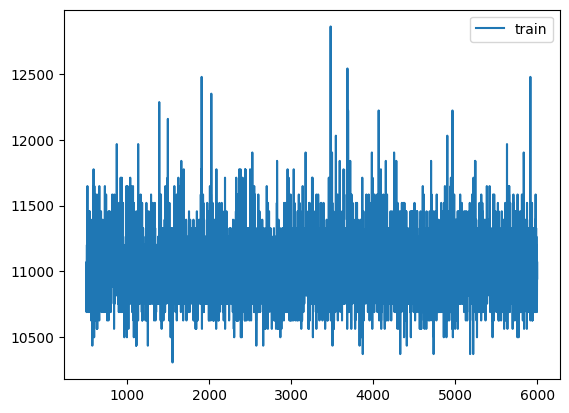

In [ ]:
plt.plot(list(train_history.keys())[500:], list(train_history.values())[500:], label='train')
# plt.plot(val_history.keys(), val_history.values(), label='validation')
plt.legend()
plt.show()

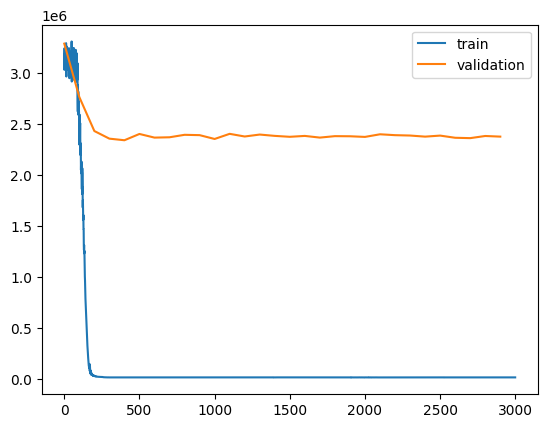

In [ ]:
plt.plot(list(train_history.keys()), list(train_history.values()), label='train')
plt.plot(val_history.keys(), val_history.values(), label='validation')
plt.legend()
plt.show()

In [ ]:
'''
# My results
At relu, model is stuck around 25k with 3x1000 steps with xavier
AT relu, moedl went to 9k and then exploded at 3x1000 steps with kaiming; then at 14k
At gelu, model is stuck atound 10k

Adam is better than AdamW for this task
'''

'\n# My results\nAt relu, model is stuck around 25k with 3x1000 steps with xavier\nAT relu, moedl went to 9k and then exploded at 3x1000 steps with kaiming; then at 14k\nAt gelu, model is stuck atound 10k\n\nAdam is better than AdamW for this task\n'

# Inference

In [ ]:
fen_sample ='rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1'

In [ ]:
def get_score(fen_sample):
    # encoding
    encoder_object = ChessEncoder()
    encoded_fen = torch.tensor(encoder_object.encode_fen(fen_i), dtype=torch.int32).to(device).view(70)
    # print(encoded_fen.shape)
    bs=1
    model = MLPEngine(embedding_dim=32).to(device)
    model.eval()
    y_pred = model(encoded_fen)
    return y_pred.item()
    # run the model

In [ ]:
get_score(fen_sample)

-1.1649487018585205

# TODO
- [x] do inference
- [ ] look for other/ better dataset
- [ ] add regularisation
- [x] add proper initialisation
- [ ] Then start to think about architectural changes
- [ ] do some hyperparameter tuning, maybe grid search or something
  - [x] **learning rate scheduler
  - [ ] embedding dimension changes
  - [ ] model neurons ++
  - [x] **batch/ layer normalisation
  - [ ] different precision
  - [ ] custom loss function of the specific problem
  - [ ] Check for potential gradient vanishing/exploding

current precision is giving loss as int, fix it